In [1]:
from __future__ import print_function

import sys
import os
from glob import glob
from time import time
%matplotlib inline
#%load_ext autoreload
#%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np
import math
#plt.rcParams['figure.figsize'] = 10,8
import datetime

from   invisible_cities.database import load_db
from   invisible_cities.core.system_of_units_c import SystemOfUnits
import invisible_cities.sierpe.blr as blr
import invisible_cities.core.mpl_functions as mpl
import invisible_cities.reco.wfm_functions as wfm
import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.core.peak_functions_c as cpf
import invisible_cities.reco.pmaps_functions as pf
import invisible_cities.core.sensor_functions as sf
from   invisible_cities.core.core_functions import define_window

import invisible_cities.core.pmaps_functions_c as cpm
from   invisible_cities.core.core_functions import lrange
 
units = SystemOfUnits()
t0 = time()

In [2]:
import S1S2prop as prop

## Open 1 Krypton MC file

In [3]:
#%%
mydf_file = os.environ['IC_DATA']+'/Kr/pmaps_NEXT_v0_08_09_Kr_ACTIVE_1_0_7bar__10000.root.h5'
print(mydf_file)

mydf = pf.read_pmaps(mydf_file)
#mydf
list(map(type, mydf))
S1df   = mydf[0]
S2df   = mydf[1]
S2Sidf = mydf[2]
print('S1df entries (tbins x events):',len(S1df))
print('S2df entries (tbins x events):',len(S2df))
print('S2Sidf entries:',len(S2Sidf))
type(S1df)
print('Keys of S1df panda dataframe: {} '.format(S1df.keys()))
print('Keys of S2df panda dataframe: {} '.format(S2df.keys()))
print('Keys of S2Sidf panda dataframe: {} '.format(S2Sidf.keys()))

# Convert S12df object  (an S12 pytable read as a PD dataframe) and return an S12L dictionary (list of dict, first dict)
S1dict = pf.s12df_to_s12l(S1df,10000)
S2dict = pf.s12df_to_s12l(S2df,10000)

evid_S1min = sorted(S1dict.keys())[0]
evid_S1max = sorted(S1dict.keys())[-1]
evid_S2min = sorted(S2dict.keys())[0]
evid_S2max = sorted(S2dict.keys())[-1]
print('First/last event ID (first item in sorted S1 dictionary): {}/{}'.format(evid_S1min,evid_S1max))
print('First/last event ID (first item in sorted S2 dictionary): {}/{}'.format(evid_S2min,evid_S2max))
print('Total number of events in S1 = {}'.format(len(S1dict)))
print('Total number of events in S2 = {}'.format(len(S2dict)))
len(S1dict), type(S1dict), len(S2dict), type(S2dict)


/Users/neus/InvCities/data/Kr/pmaps_NEXT_v0_08_09_Kr_ACTIVE_1_0_7bar__10000.root.h5
S1df entries (tbins x events): 51993
S2df entries (tbins x events): 91086
S2Sidf entries: 45115
Keys of S1df panda dataframe: Index(['event', 'evtDaq', 'peak', 'time', 'ene'], dtype='object') 
Keys of S2df panda dataframe: Index(['event', 'evtDaq', 'peak', 'time', 'ene'], dtype='object') 
Keys of S2Sidf panda dataframe: Index(['event', 'evtDaq', 'peak', 'nsipm', 'nsample', 'ene'], dtype='object') 
First/last event ID (first item in sorted S1 dictionary): 0/9999
First/last event ID (first item in sorted S2 dictionary): 0/9999
Total number of events in S1 = 6980
Total number of events in S2 = 9977


(6980, dict, 9977, dict)

### Get all S1 and S2 in file:  

In [4]:
S1 = prop.S12Prop(S1dict)
S2 = prop.S12Prop(S2dict)

type(S1)
S2.length(), S1.length()
S1._dict().keys() == S2._dict().keys()

False

### Get S1/S2 for events containing 1S1 & 1S2:

In [5]:
S1map = S1.S1S2mapd(S2)[0]
S2map = S1.S1S2mapd(S2)[1]
S1map._dict().keys() == S2map._dict().keys()

True

In [6]:
len(S1map.wS12_)

6973

### S1 features for "all" S1 ("all" = no mapping with S2)

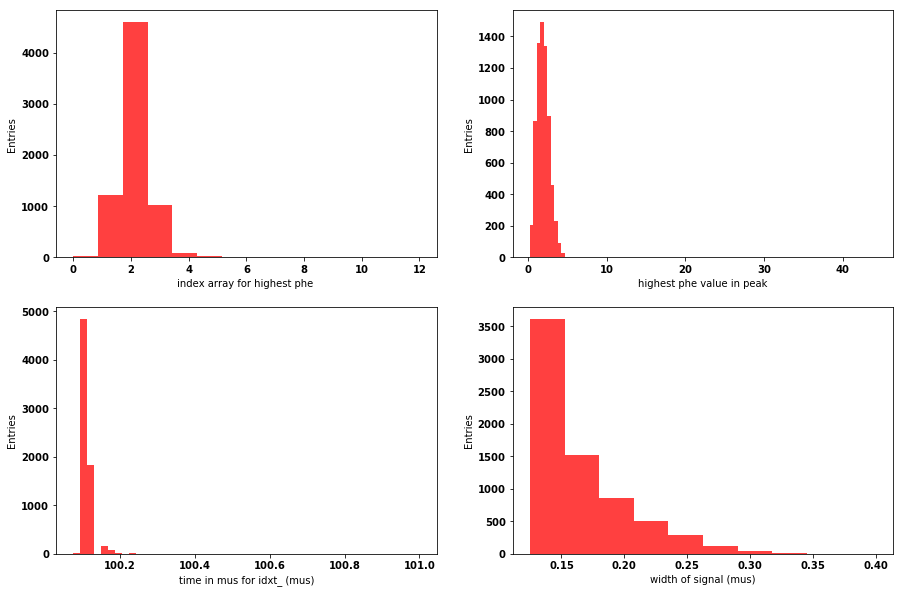

In [7]:
fig = plt.subplots(nrows = 1, ncols=2, figsize=(15, 10))
plt.rc('font', weight='bold')
plt.subplot(221)   
prop.multh(S1.idxt_,    14,  color= "red",title= "", xlabel ="index array for highest phe ", ylabel= "Entries")
plt.subplot(222)   
prop.multh(S1.S12SigE_, 100, color= "red",title= "", xlabel ="highest phe value in peak", ylabel= "Entries")
plt.subplot(223)   
prop.multh(S1.S12Sigt_, 50, color= "red",title= "", xlabel ="time in mus for idxt_ (mus)", ylabel= "Entries")
plt.subplot(224)   
prop.multh(S1.wS12_,    10 , color= "red",title= "", xlabel ="width of signal (mus)", ylabel= "Entries")
plt.show()


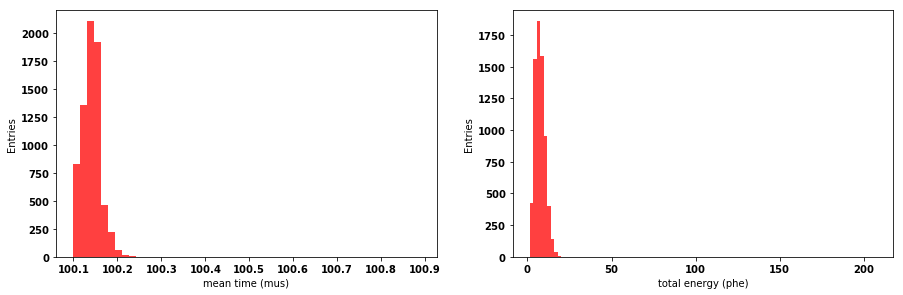

In [8]:
fig = plt.subplots(nrows = 1, ncols=2, figsize=(15, 10))
plt.subplot(221)   
prop.multh(S1.tmean_, 50, color= "red",title= "", xlabel ="mean time (mus)", ylabel= "Entries")
plt.subplot(222)   
prop.multh(S1.E_,   100 , color= "red",title= "", xlabel ="total energy (phe)", ylabel= "Entries")
plt.show()

### Obtain drift length:

In [9]:
S1t = np.array(S1map.S12Sigt_)
S2t = np.array(S2map.S12Sigt_)
z = np.subtract(S2t,S1t)
len(S1t), len(S2t)

(6973, 6973)

### S2 features for "all" S1 ("all" = no mapping with S1)

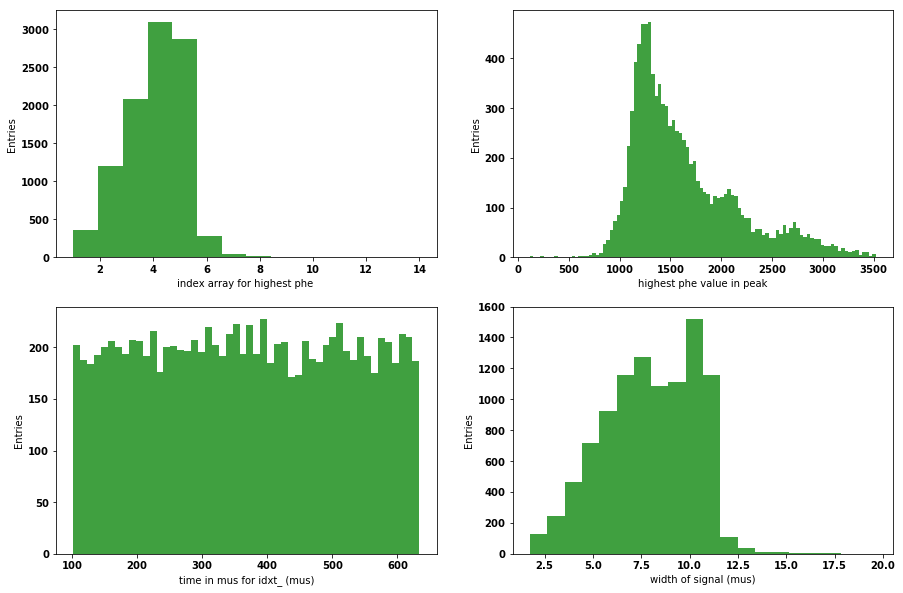

In [10]:
fig = plt.subplots(nrows = 1, ncols=2, figsize=(15, 10))
plt.rc('font', weight='bold')
plt.subplot(221)   
prop.multh(S2.idxt_,    14,  color= "green",title= "", xlabel ="index array for highest phe ", ylabel= "Entries")
plt.subplot(222)   
prop.multh(S2.S12SigE_, 100, color= "green",title= "", xlabel ="highest phe value in peak", ylabel= "Entries")
plt.subplot(223)   
prop.multh(S2.S12Sigt_, 50, color= "green",title= "", xlabel ="time in mus for idxt_ (mus)", ylabel= "Entries")
plt.subplot(224)   
prop.multh(S2.wS12_,    20 , color= "green",title= "", xlabel ="width of signal (mus)", ylabel= "Entries")
plt.show()



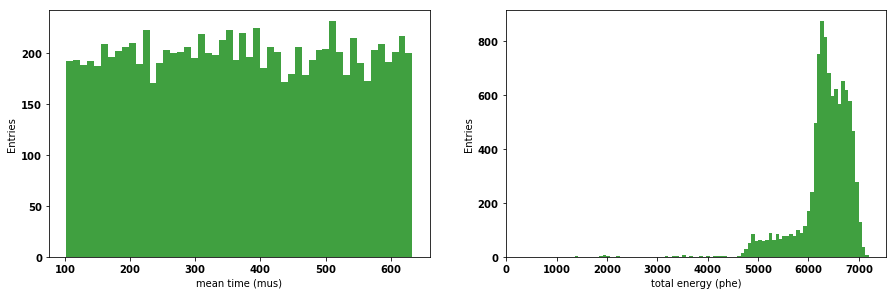

In [11]:
fig = plt.subplots(nrows = 1, ncols=2, figsize=(15, 10))
plt.subplot(221)   
prop.multh(S2.tmean_, 50, color= "green",title= "", xlabel ="mean time (mus)", ylabel= "Entries")
plt.subplot(222)   
prop.multh(S2.E_,   100 , color= "green",title= "", xlabel ="total energy (phe)", ylabel= "Entries")
plt.show()

### Analyze events with S1&S2: (to do: plot it above)

### Obtain drift length:

In [12]:
S1t = np.array(S1map.S12Sigt_)
S2t = np.array(S2map.S12Sigt_)
z = np.subtract(S2t,S1t)
len(S1t), len(S2t)

(6973, 6973)

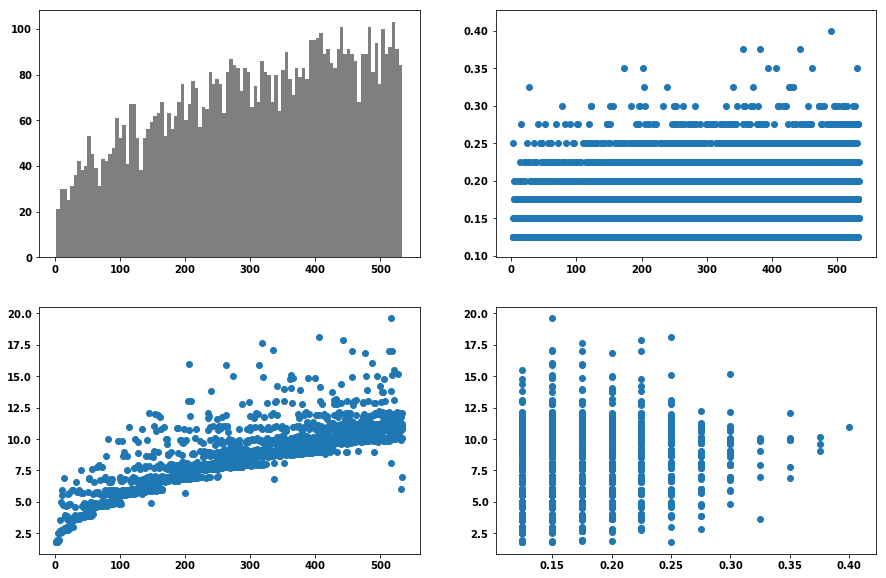

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(15, 10))
plt.subplot(221)   
plt.hist(z,100,color='black',alpha=0.5)
plt.subplot(222)   
plt.scatter(z,S1map.wS12_)
plt.subplot(223) 
plt.scatter(z,S2map.wS12_)
plt.subplot(224) 
plt.scatter(S1map.wS12_,S2map.wS12_)
plt.show()

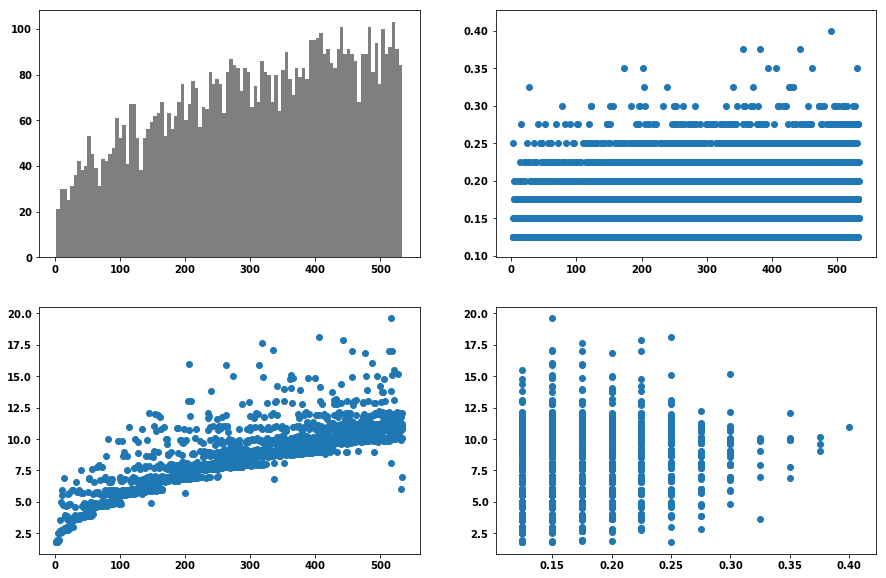

In [14]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(15, 10))
plt.subplot(221)   
plt.hist(z,100,color='black',alpha=0.5)
plt.subplot(222)   
plt.scatter(z,S1map.wS12_)
plt.subplot(223) 
plt.scatter(z,S2map.wS12_)
plt.subplot(224) 
plt.scatter(S1map.wS12_,S2map.wS12_)
plt.show()

### Save a nice plot

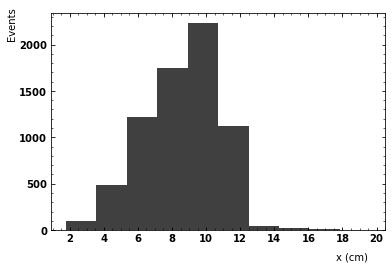

In [15]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

#fig = plt.subplots(nrows = 1, ncols=2, figsize=(15, 10))
h1 = prop.h1(S2map.wS12_, 10 , color="black",title="", xlabel ="x (cm)", ylabel = "Events")
h1.show()
#h2 = prop.h1(_S2map.wS12_, 10 ,0., 0.4, color="green",title="", xlabel ="x (cm)", ylabel = "Events")
#h2.show()
#h1.savefig("h2")
#h2.savefig("h2")